#### Information about samples: the data I am using in this example is published and can be find here: https://zenodo.org/records/6578617
#### the paper: https://www.nature.com/articles/s41586-022-05060-x
##### CK158 - control P1 (healthy heart zone)
##### CK159 - RZ/BZ P5 (remote / border heart zone)
##### CK361 - IZ P 10 (ischaemic heart zone)

In [3]:
import scanpy as sc

Load the dataset with scanpy

In [5]:
adata = sc.read_10x_h5('/Users/dana/Desktop/AHI/Programming Exam/raw_data/CK158/outs/snRNA_CK158_filtered_feature_bc_matrix.h5')

/Users/dana/anaconda3/envs/scrna_analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/dana/anaconda3/envs/scrna_analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
# Makes the index (gene name) unique by appending a number string to each duplicate index element: ‘1’, ‘2’, etc.
# some variables (genes) appear more than once which can lead to errors or unintended behavior for downstream analysis

adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 14296 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [7]:
# simple filtering
sc.pp.filter_cells(adata, min_genes=200) #filters out cells with fewer than 200 genes
sc.pp.filter_genes(adata, min_cells=50) #filteres out genes that are found in fewer than 50 cells

In [8]:
# check the number of cells and genes after filtering
adata

AnnData object with n_obs × n_vars = 14279 × 20326
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [9]:
# print the sparse matrix
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 33432725 stored elements and shape (14279, 20326)>

In [10]:
# check the max value to know if it is normalized or not (raw should not be normalized)
adata.X.max()

np.float32(10468.0)

In [11]:
# save raw counts as an additional layer in anndata object might need it later for the downstream analysis 

adata.layers['raw_counts'] = adata.X

In [12]:
# print to check if the raw counts are actually saved 
adata

AnnData object with n_obs × n_vars = 14279 × 20326
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    layers: 'raw_counts'

In [13]:
# print cell barcodes df (only has first 2 columns because no further analysis was done yet)
adata.obs

,n_genes
AAACCCACAAAGGAGA-1,1679
AAACCCACAGAGATGC-1,4190
AAACCCACATCGGATT-1,7048
AAACCCAGTAACGGTG-1,2702
AAACCCAGTCCAGAAG-1,519
...,...
TTTGTTGGTGTGATGG-1,3402
TTTGTTGGTTTGATCG-1,1532
TTTGTTGTCAACCGAT-1,4402
TTTGTTGTCACAACCA-1,1341


In [14]:
# print gene indexes df (only has first 5 columns because no further analysis was done yet)
adata.var

,gene_ids,feature_types,genome,n_cells
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,61
AL627309.5,ENSG00000241860,Gene Expression,GRCh38,178
LINC01409,ENSG00000237491,Gene Expression,GRCh38,1592
LINC01128,ENSG00000228794,Gene Expression,GRCh38,2424
LINC00115,ENSG00000225880,Gene Expression,GRCh38,258
...,...,...,...,...
AL354822.1,ENSG00000278384,Gene Expression,GRCh38,1041
AL592183.1,ENSG00000273748,Gene Expression,GRCh38,5039
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,222
AC004556.3,ENSG00000276345,Gene Expression,GRCh38,81


In [15]:
# load additional modules for further analysis to use functions that are not available in scanpy 

import numpy as np
import seaborn as sns
from scipy.stats import median_abs_deviation

In [16]:
# mitochondrial genes detection
# this creates a new column "mt" in adata.var dataframe which contains True if gene is mitochondrial and False if not
adata.var["mt"] = adata.var_names.str.startswith("MT-")

In [17]:
adata.var

,gene_ids,feature_types,genome,n_cells,mt
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,61,False
AL627309.5,ENSG00000241860,Gene Expression,GRCh38,178,False
LINC01409,ENSG00000237491,Gene Expression,GRCh38,1592,False
LINC01128,ENSG00000228794,Gene Expression,GRCh38,2424,False
LINC00115,ENSG00000225880,Gene Expression,GRCh38,258,False
...,...,...,...,...,...
AL354822.1,ENSG00000278384,Gene Expression,GRCh38,1041,False
AL592183.1,ENSG00000273748,Gene Expression,GRCh38,5039,False
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,222,False
AC004556.3,ENSG00000276345,Gene Expression,GRCh38,81,False


In [18]:
# calculate the percentage of mitochondrial rna in the cell and removes if more then 20% (can be adjusted to the lower or higher value 
# depending on the quality of the sample and type of the tissue)
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True)
adata

AnnData object with n_obs × n_vars = 14279 × 20326
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts'

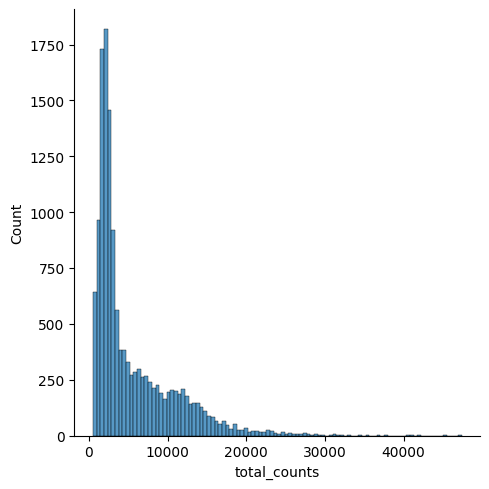

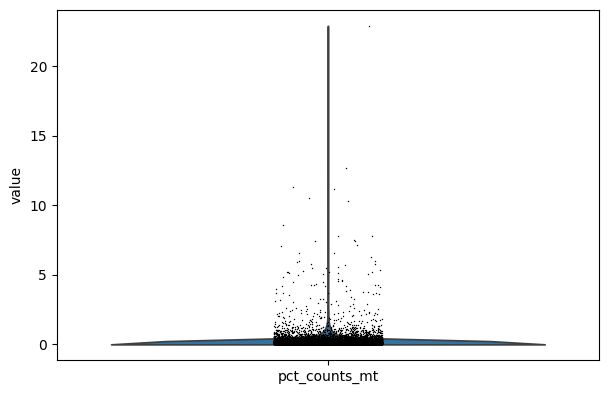

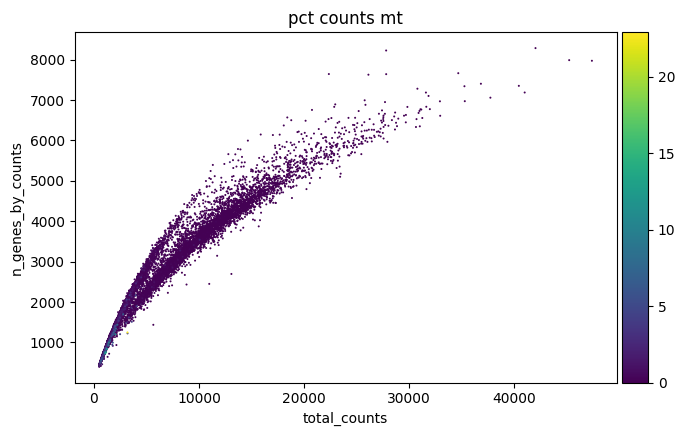

In [19]:
# plot parameters important for the quality control (QC)

p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

p3:
x (total_counts): The total number of counts (e.g., UMIs) detected in each cell (amount of RNA)
y (n_genes_by_counts): The number of genes detected in each cell, based on non-zero counts
Color (pct_counts_mt): Each cell is colored based on the percentage of mitochondrial RNA counts. High mitochondrial percentages might indicate stressed or dying cells

	•	Healthy Cells: moderate values for both total_counts and n_genes_by_counts, and lower pct_counts_mt
	•	Low-Quality Cells: have low total_counts and n_genes_by_counts, but higher pct_counts_mt 
	•	Doublets/Multiplets: outliers with very high total_counts and n_genes_by_counts

After plotting qc matrices we can see that only a small fraction of cells contain a high count of mt genes (plot p2)

In [20]:
# function for automatic thresholding via MAD (median absolute deviations) MAD = median(|Xi - median(X)|) with Xi = respective QC metric of an observation and describes a robust statistic of the variability of the metric
# that takes a metric a column in .obs and the number of MADs 

def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M)
    return outlier

In [21]:
# cells are marked as outliers if they differ by 5 MADs (which is from the best QC practices in the field)

adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5))

adata.obs.outlier.value_counts()

outlier
False    13622
True       657
Name: count, dtype: int64

In [22]:
# for MT filter out cells that are outlining for more then 3 standard deviations (MADs) or if more than 10%

adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 10)

adata.obs.mt_outlier.value_counts()

mt_outlier
False    12503
True      1776
Name: count, dtype: int64

In [23]:
# find out how many cells were filtered out

print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 14279
Number of cells after filtering of low quality cells: 11855


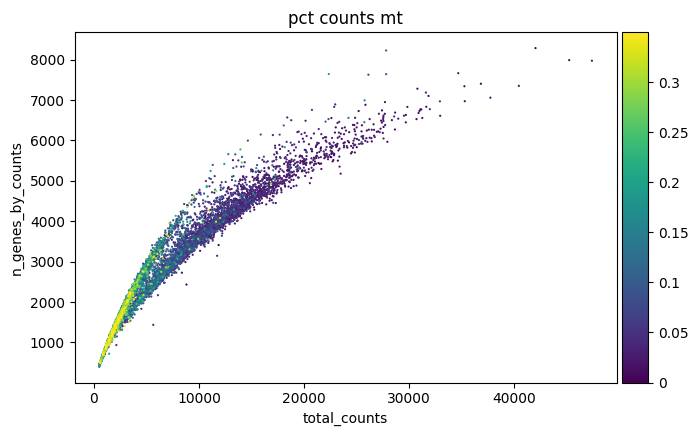

In [24]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [25]:
adata

AnnData object with n_obs × n_vars = 11855 × 20326
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts'

In [27]:
# Predict doublets using Scrublet
# Doublets are defined as two cells that are sequenced under the same cellular barcode, for example, 
# if they were captured in the same droplet

sc.pp.scrublet(adata)

In [28]:
adata

AnnData object with n_obs × n_vars = 11855 × 20326
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet'
    layers: 'raw_counts'

In [29]:
adata.obs

,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,outlier,mt_outlier,doublet_score,predicted_doublet
AAACCCACAAAGGAGA-1,1679,1667,7.419381,2587.0,7.858641,14.418245,3.0,1.386294,0.115964,False,False,0.010155,False
AAACCCACAGAGATGC-1,4190,4170,8.335911,12986.0,9.471704,31.018019,7.0,2.079442,0.053904,False,False,0.145194,False
AAACCCACATCGGATT-1,7048,6993,8.852808,25756.0,10.156462,22.666563,43.0,3.784190,0.166951,False,False,0.267951,False
AAACCCAGTAACGGTG-1,2702,2692,7.898411,6357.0,8.757469,28.346704,3.0,1.386294,0.047192,False,False,0.034132,False
AAACCCAGTCCAGAAG-1,519,515,6.246107,623.0,6.436151,18.780096,0.0,0.000000,0.000000,False,False,0.012754,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGACACGA-1,4625,4609,8.435983,15050.0,9.619200,27.800664,3.0,1.386294,0.019934,False,False,0.050879,False
TTTGTTGGTGTGATGG-1,3402,3387,8.127995,9001.0,9.105202,24.963893,4.0,1.609438,0.044440,False,False,0.031013,False
TTTGTTGTCAACCGAT-1,4402,4385,8.386173,13660.0,9.522301,28.448023,5.0,1.791759,0.036603,False,False,0.075426,False
TTTGTTGTCACAACCA-1,1341,1331,7.194437,1938.0,7.569928,12.693498,3.0,1.386294,0.154799,False,False,0.016985,False


# Run automated preprocessing for three samples 

In [30]:
import scanpy as sc

In [32]:
# load all samples as dictionaries of sample name as a key adn andata object as a value
# create automatic loading by using for loop and f string (path has to be changed if used in different location)

sample_list = ['CK158','CK159','CK361']
adata_dict = {}

for sample in sample_list:
    adata_dict[f'{sample}'] = sc.read_10x_h5(
        filename=f'/Users/dana/Desktop/AHI/Programming Exam/raw_data/{sample}/outs/snRNA_{sample}_filtered_feature_bc_matrix.h5')

/Users/dana/anaconda3/envs/scrna_analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/dana/anaconda3/envs/scrna_analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/dana/anaconda3/envs/scrna_analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/dana/anaconda3/envs/scrna_analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/dana/anaconda3/envs/scrna_analysis/lib/python3.10/sit

In [33]:
adata_dict

{'CK158': AnnData object with n_obs × n_vars = 14296 × 36601
     var: 'gene_ids', 'feature_types', 'genome',
 'CK159': AnnData object with n_obs × n_vars = 11697 × 36601
     var: 'gene_ids', 'feature_types', 'genome',
 'CK361': AnnData object with n_obs × n_vars = 7436 × 36601
     var: 'gene_ids', 'feature_types', 'genome'}

In [34]:
for adata in adata_dict.values():
   adata.var_names_make_unique()
   adata.obs_names_make_unique()

In [35]:
for sample_name, adata in adata_dict.items():
   print(sample_name)
   print(adata.X.max())
   adata.layers['raw_counts'] = adata.X
   print(adata)
   sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
   sc.pp.filter_genes(adata, min_cells=50) #get rid of genes that are found in fewer than 50 cells
   print(f"Number of cells after filtering: {adata.n_obs}")
   print(f"Number of genes after filtering: {adata.n_vars}")
   adata.var["mt"] = adata.var_names.str.startswith("MT-")
   sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True)
   adata_dict[sample_name] = adata

CK158
10468.0
AnnData object with n_obs × n_vars = 14296 × 36601
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'raw_counts'
Number of cells after filtering: 14279
Number of genes after filtering: 20326
CK159
12128.0
AnnData object with n_obs × n_vars = 11697 × 36601
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'raw_counts'
Number of cells after filtering: 11688
Number of genes after filtering: 18475
CK361
6609.0
AnnData object with n_obs × n_vars = 7436 × 36601
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'raw_counts'
Number of cells after filtering: 7436
Number of genes after filtering: 13467


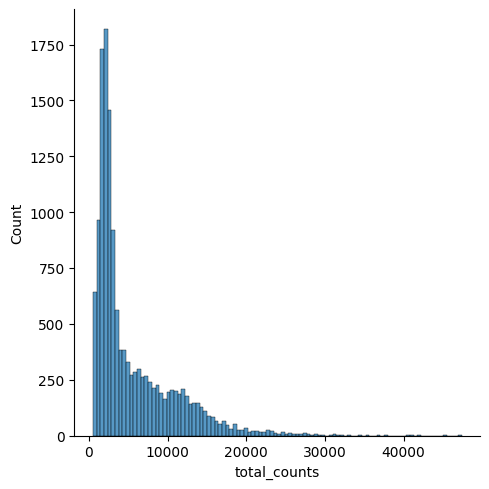

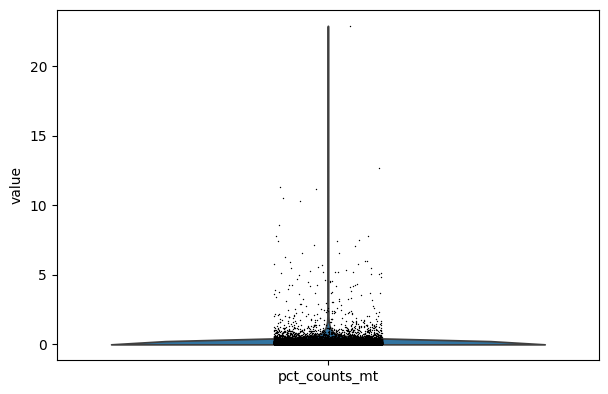

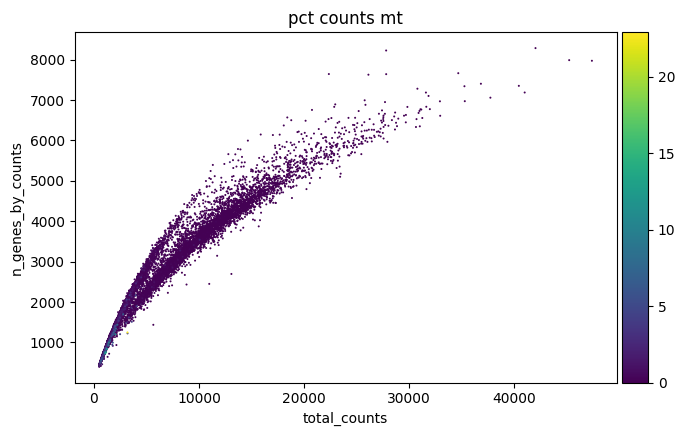

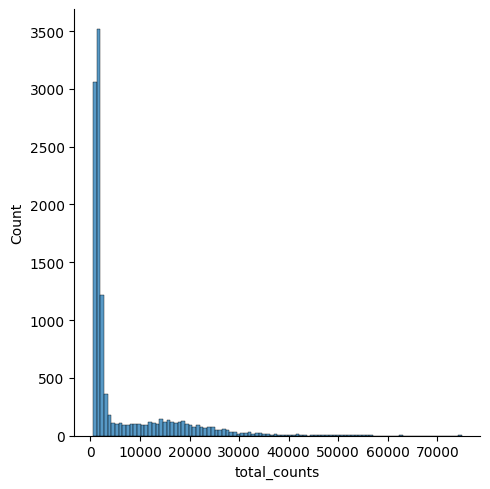

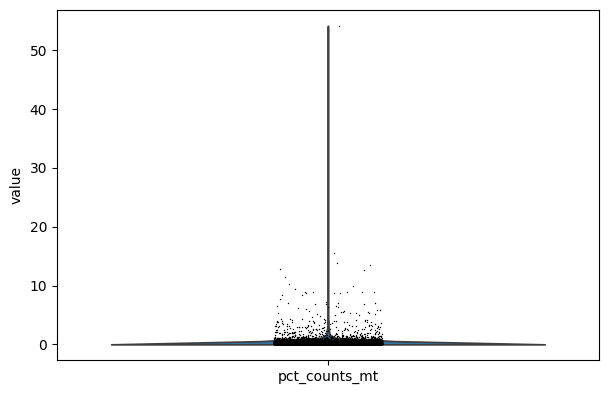

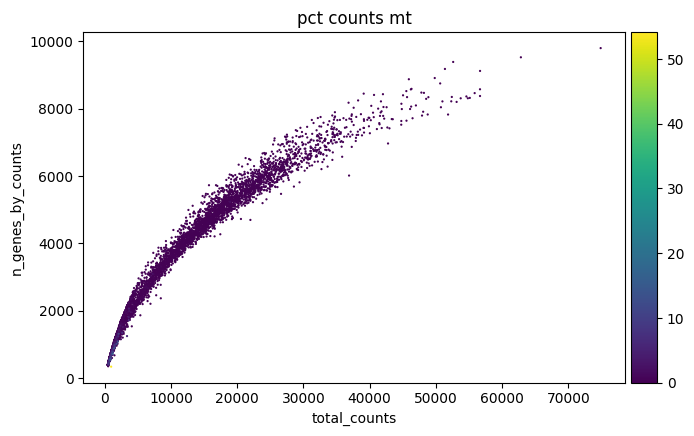

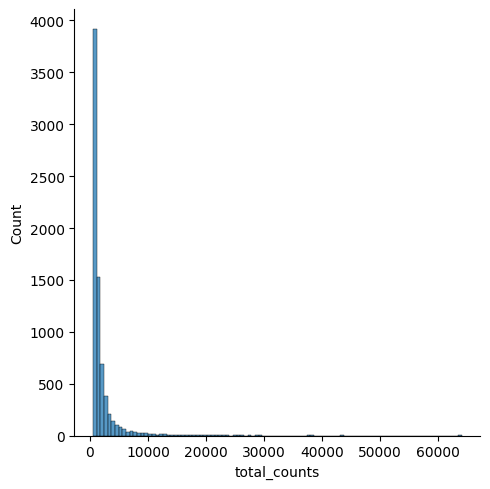

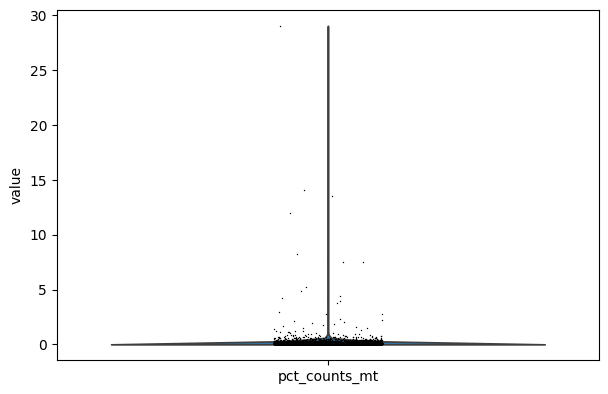

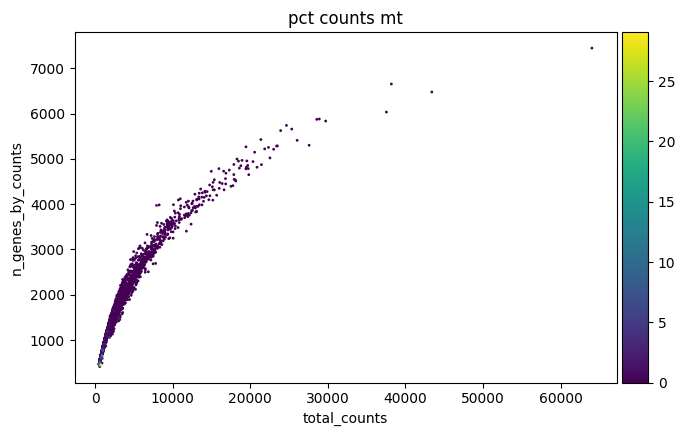

In [36]:
for sample_name, adata in adata_dict.items():
   p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
   p2 = sc.pl.violin(adata, "pct_counts_mt")
   p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [37]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M)
    return outlier

In [38]:
for sample_name, adata in adata_dict.items():
    print(sample_name)
    adata.obs["outlier"] = (is_outlier(adata, "log1p_total_counts", 5) | is_outlier(adata, "log1p_n_genes_by_counts", 5) | is_outlier(adata, "pct_counts_in_top_20_genes", 5))
    print(adata.obs.outlier.value_counts())
    adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (adata.obs["pct_counts_mt"] > 25)
    print(adata.obs.mt_outlier.value_counts())
    print(f"Total number of cells: {adata.n_obs}")
    adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
    print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")
    print(adata)
    adata_dict[sample_name] = adata

CK158
outlier
False    13622
True       657
Name: count, dtype: int64
mt_outlier
False    12503
True      1776
Name: count, dtype: int64
Total number of cells: 14279
Number of cells after filtering of low quality cells: 11855
AnnData object with n_obs × n_vars = 11855 × 20326
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts'
CK159
outlier
False    11096
True       592
Name: count, dtype: int64
mt_outlier
False    10376
True      1312
Name: count, dtype: int64
Total number of cells: 11688
Number of cells after filtering of low quality cells: 9789
AnnData object with n_obs × n_vars = 9789 × 18475
    obs: 'n_genes'

CK158


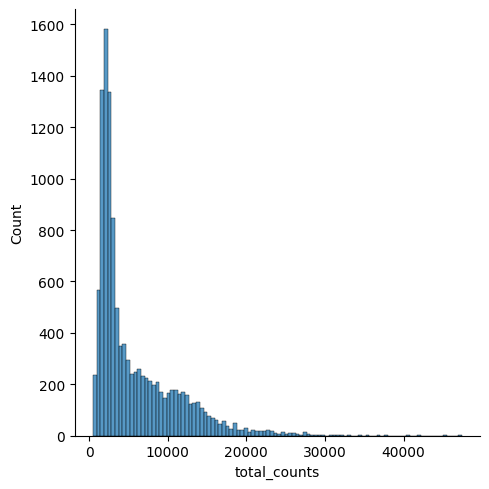

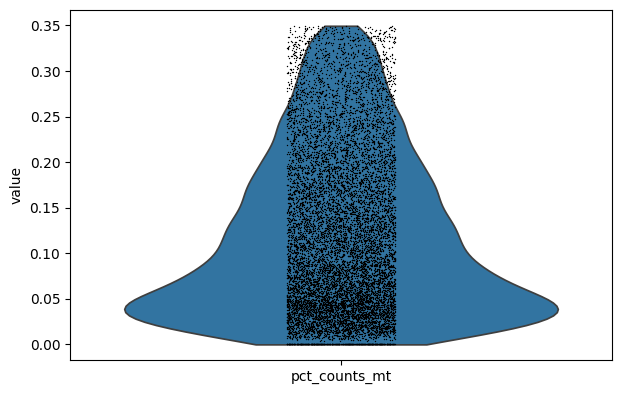

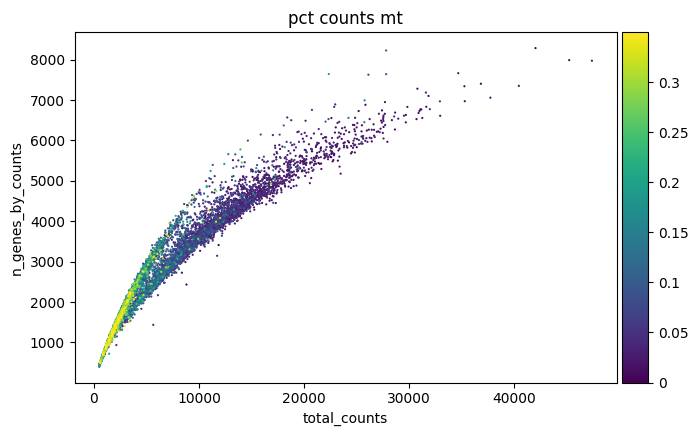

CK159


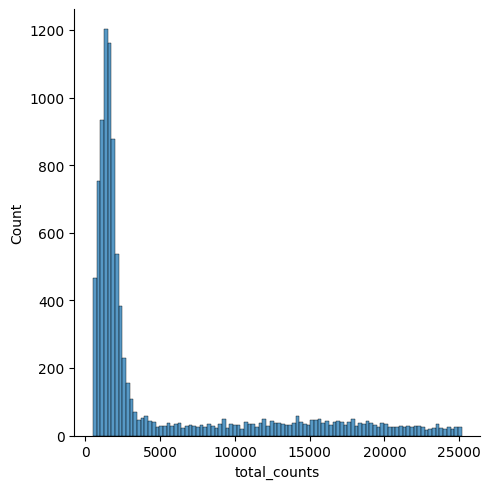

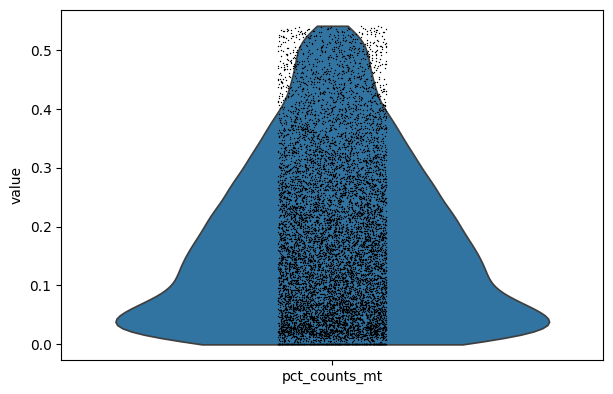

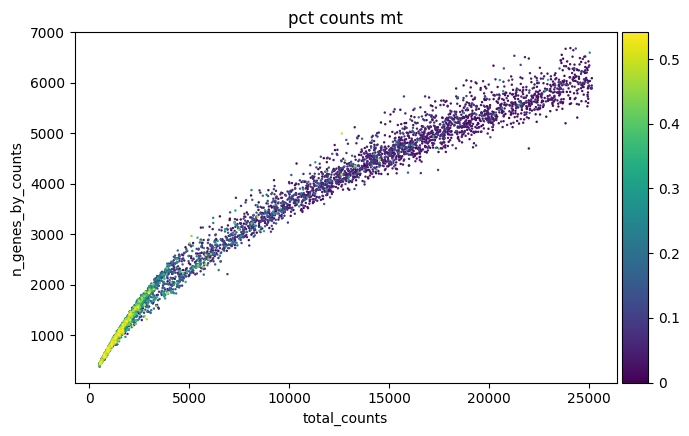

CK361


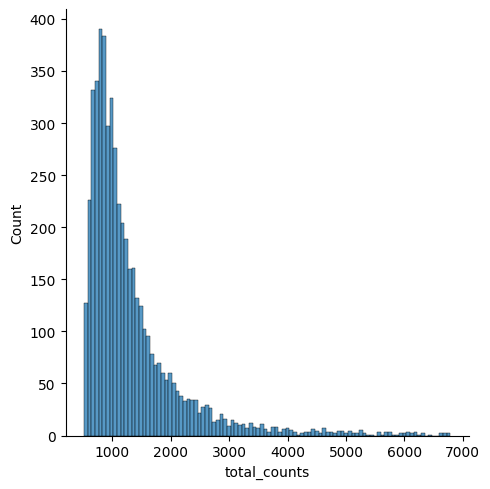

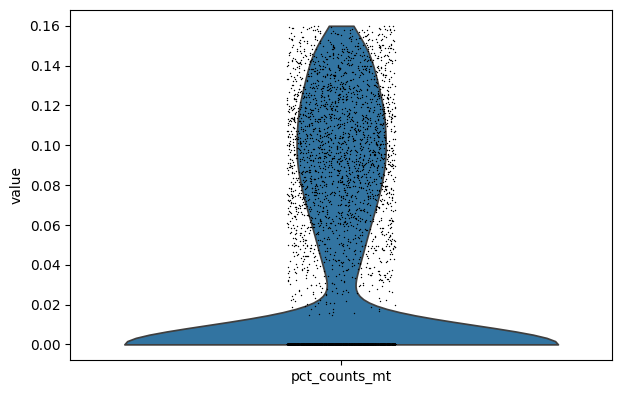

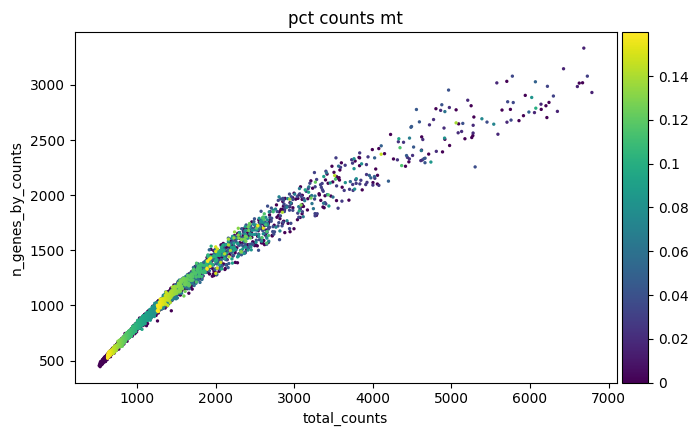

In [39]:
for sample_name, adata in adata_dict.items():
   print(sample_name)
   p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
   p2 = sc.pl.violin(adata, "pct_counts_mt")
   p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [40]:
adata_dict

{'CK158': AnnData object with n_obs × n_vars = 11855 × 20326
     obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     layers: 'raw_counts',
 'CK159': AnnData object with n_obs × n_vars = 9789 × 18475
     obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     layers: 'raw_counts',
 'CK361': A

In [41]:
for sample_name, adata in adata_dict.items():
   sc.pp.scrublet(adata)
   adata_dict[sample_name] = adata

In [42]:
adata_dict

{'CK158': AnnData object with n_obs × n_vars = 11855 × 20326
     obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'doublet_score', 'predicted_doublet'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'scrublet'
     layers: 'raw_counts',
 'CK159': AnnData object with n_obs × n_vars = 9789 × 18475
     obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'doublet_score', 'predicted_doublet'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pc

In [43]:
# combine all three datasets togather 

concatenated_adata = sc.concat(
    list(adata_dict.values()),
    axis=0,  # Concatenate along the obs axis
    label='batch',  # Add a batch column to distinguish between samples
    keys=adata_dict.keys(),  # Use sample names as keys
    join='inner')  # Include only intersection, features (genes) that are present in all datasets

/Users/dana/anaconda3/envs/scrna_analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [44]:
concatenated_adata

AnnData object with n_obs × n_vars = 26803 × 13157
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'doublet_score', 'predicted_doublet', 'batch'
    layers: 'raw_counts'

In [45]:
concatenated_adata.obs['batch']

AAACCCACAAAGGAGA-1    CK158
AAACCCACAGAGATGC-1    CK158
AAACCCACATCGGATT-1    CK158
AAACCCAGTAACGGTG-1    CK158
AAACCCAGTCCAGAAG-1    CK158
                      ...  
TTTGGTTTCCCATGGG-1    CK361
TTTGGTTTCCGAAGGA-1    CK361
TTTGTTGTCCAATGCA-1    CK361
TTTGTTGTCGTGTTCC-1    CK361
TTTGTTGTCGTTCAGA-1    CK361
Name: batch, Length: 26803, dtype: category
Categories (3, object): ['CK158', 'CK159', 'CK361']

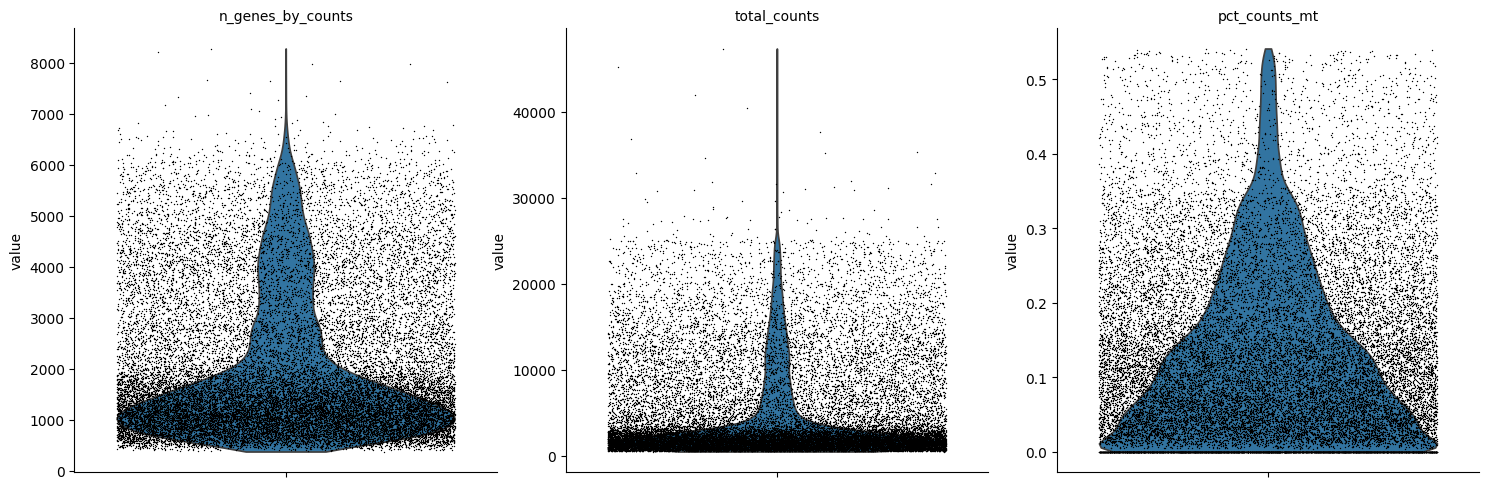

In [46]:
sc.pl.violin(
    concatenated_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True)

Additional manual filtering step based on the QC plots

In [47]:
concatenated_adata = concatenated_adata[concatenated_adata.obs.n_genes_by_counts < 7000, :].copy()
concatenated_adata = concatenated_adata[concatenated_adata.obs.total_counts < 30000, :].copy()

/Users/dana/anaconda3/envs/scrna_analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/dana/anaconda3/envs/scrna_analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


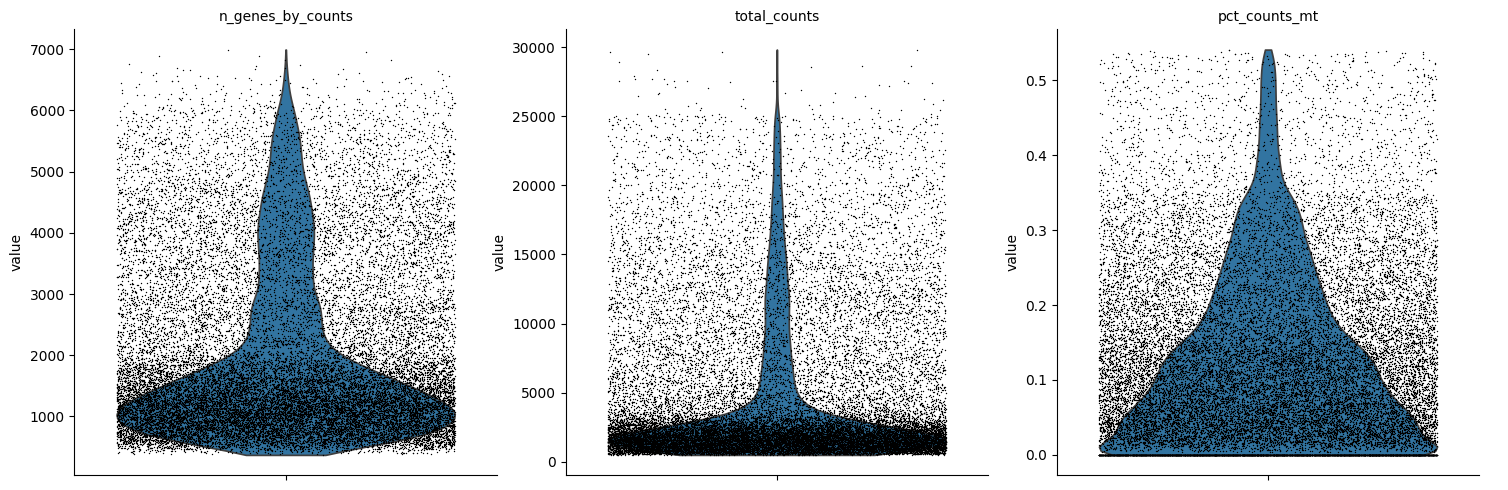

In [48]:
sc.pl.violin(
    concatenated_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True)

In [49]:
concatenated_adata.obs['predicted_doublet'].value_counts()

predicted_doublet
False    26193
True       584
Name: count, dtype: int64

In [50]:
# filter out all cells where predicted doublet = True (or otherwise only keep if False)

concatenated_adata = concatenated_adata[concatenated_adata.obs['predicted_doublet'] != True].copy()

/Users/dana/anaconda3/envs/scrna_analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [51]:
concatenated_adata

AnnData object with n_obs × n_vars = 26193 × 13157
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'doublet_score', 'predicted_doublet', 'batch'
    layers: 'raw_counts'

In [52]:
concatenated_adata.obs

,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,outlier,mt_outlier,doublet_score,predicted_doublet,batch
AAACCCACAAAGGAGA-1,1679,1667,7.419381,2587.0,7.858641,14.418245,3.0,1.386294,0.115964,False,False,0.010155,False,CK158
AAACCCACAGAGATGC-1,4190,4170,8.335911,12986.0,9.471704,31.018019,7.0,2.079442,0.053904,False,False,0.145194,False,CK158
AAACCCACATCGGATT-1,7048,6993,8.852808,25756.0,10.156462,22.666563,43.0,3.784190,0.166951,False,False,0.267951,False,CK158
AAACCCAGTAACGGTG-1,2702,2692,7.898411,6357.0,8.757469,28.346704,3.0,1.386294,0.047192,False,False,0.034132,False,CK158
AAACCCAGTCCAGAAG-1,519,515,6.246107,623.0,6.436151,18.780096,0.0,0.000000,0.000000,False,False,0.012754,False,CK158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCCCATGGG-1,780,762,6.637258,925.0,6.830874,13.729730,1.0,0.693147,0.108108,False,False,0.355932,False,CK361
TTTGGTTTCCGAAGGA-1,562,554,6.318968,657.0,6.489205,13.242009,0.0,0.000000,0.000000,False,False,0.142857,False,CK361
TTTGTTGTCCAATGCA-1,748,730,6.594413,901.0,6.804615,11.431743,1.0,0.693147,0.110988,False,False,0.074842,False,CK361
TTTGTTGTCGTGTTCC-1,711,700,6.552508,840.0,6.734591,11.904762,1.0,0.693147,0.119048,False,False,0.071553,False,CK361


In [53]:
# map metadata (patient smaple region) to the anndata objecct

condition_to_sample = {
   'CK158':'control',
   'CK159':'border zone',
   'CK361':'ischaemic zone'
}

concatenated_adata.obs['condition'] = concatenated_adata.obs['batch'].map(condition_to_sample)

In [54]:
concatenated_adata.obs

,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,outlier,mt_outlier,doublet_score,predicted_doublet,batch,condition
AAACCCACAAAGGAGA-1,1679,1667,7.419381,2587.0,7.858641,14.418245,3.0,1.386294,0.115964,False,False,0.010155,False,CK158,control
AAACCCACAGAGATGC-1,4190,4170,8.335911,12986.0,9.471704,31.018019,7.0,2.079442,0.053904,False,False,0.145194,False,CK158,control
AAACCCACATCGGATT-1,7048,6993,8.852808,25756.0,10.156462,22.666563,43.0,3.784190,0.166951,False,False,0.267951,False,CK158,control
AAACCCAGTAACGGTG-1,2702,2692,7.898411,6357.0,8.757469,28.346704,3.0,1.386294,0.047192,False,False,0.034132,False,CK158,control
AAACCCAGTCCAGAAG-1,519,515,6.246107,623.0,6.436151,18.780096,0.0,0.000000,0.000000,False,False,0.012754,False,CK158,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCCCATGGG-1,780,762,6.637258,925.0,6.830874,13.729730,1.0,0.693147,0.108108,False,False,0.355932,False,CK361,ischaemic zone
TTTGGTTTCCGAAGGA-1,562,554,6.318968,657.0,6.489205,13.242009,0.0,0.000000,0.000000,False,False,0.142857,False,CK361,ischaemic zone
TTTGTTGTCCAATGCA-1,748,730,6.594413,901.0,6.804615,11.431743,1.0,0.693147,0.110988,False,False,0.074842,False,CK361,ischaemic zone
TTTGTTGTCGTGTTCC-1,711,700,6.552508,840.0,6.734591,11.904762,1.0,0.693147,0.119048,False,False,0.071553,False,CK361,ischaemic zone


In [56]:
concatenated_adata.write('/Users/dana/Desktop/AHI/Programming Exam/filtered_data/concat_filtered_3_samples.h5ad')